In [29]:
!pip install opendatasets

In [30]:
!pip install nilearn
!pip install nibabel

In [31]:
import opendatasets as od

In [32]:
od.download(
    "https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation")

Skipping, found downloaded files in "./brats20-dataset-training-validation" (use force=True to force download)


In [33]:
od.download(
    "https://www.kaggle.com/datasets/rastislav/modelperclasseval")

Skipping, found downloaded files in "./modelperclasseval" (use force=True to force download)


In [34]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [35]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

##**Data Visualization**

Text(0.5, 1.0, 'Mask')

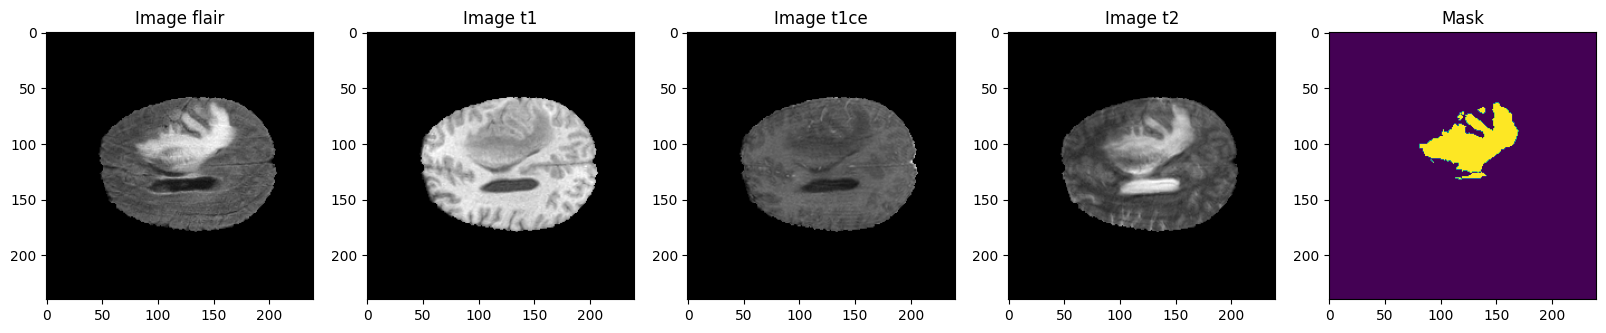

In [36]:
# Define paths for the training and validation datasets
TRAIN_DATASET_PATH = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

# Modify the paths to load data from the specified directories
test_image_flair = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001', 'BraTS20_Training_001_flair.nii')).get_fdata()
test_image_t1 = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001', 'BraTS20_Training_001_t1.nii')).get_fdata()
test_image_t1ce = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001', 'BraTS20_Training_001_t1ce.nii')).get_fdata()
test_image_t2 = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001', 'BraTS20_Training_001_t2.nii')).get_fdata()
test_mask = nib.load(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_001', 'BraTS20_Training_001_seg.nii')).get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


**Show whole nifti data -> print each slice from 3d data**

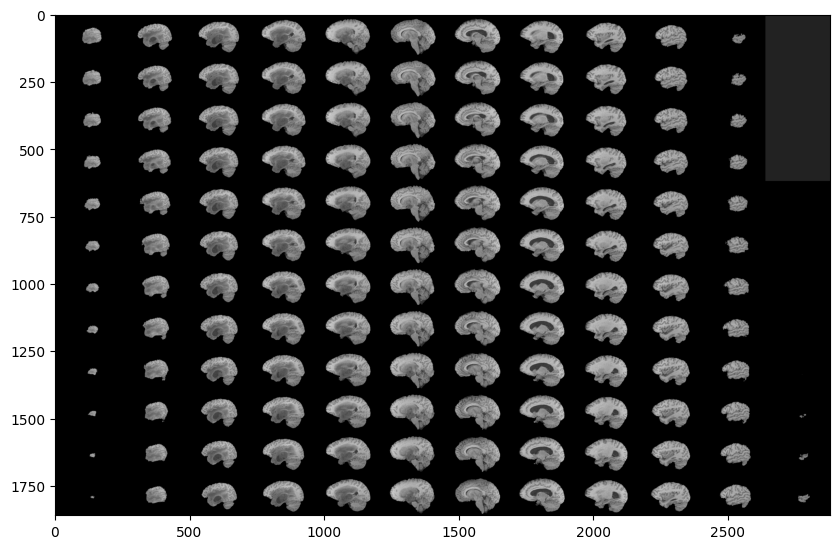

In [37]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

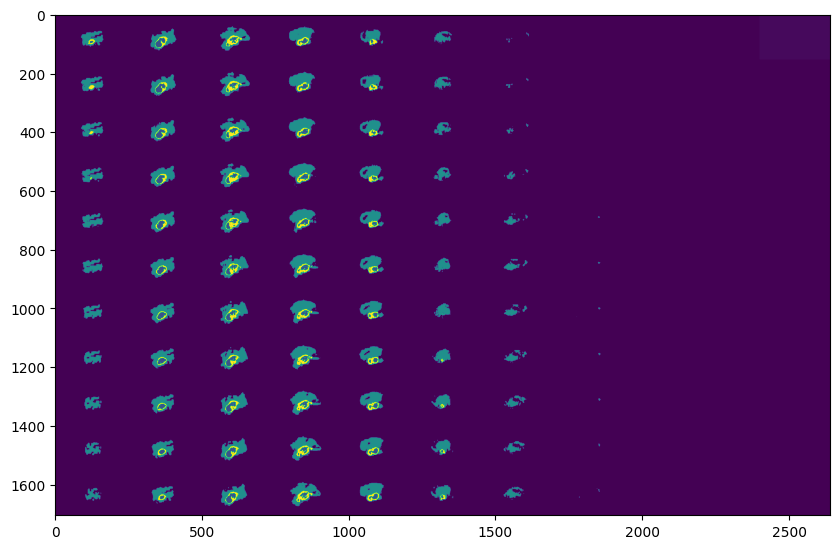

In [38]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True))

**Show segments of tumor using different effects**

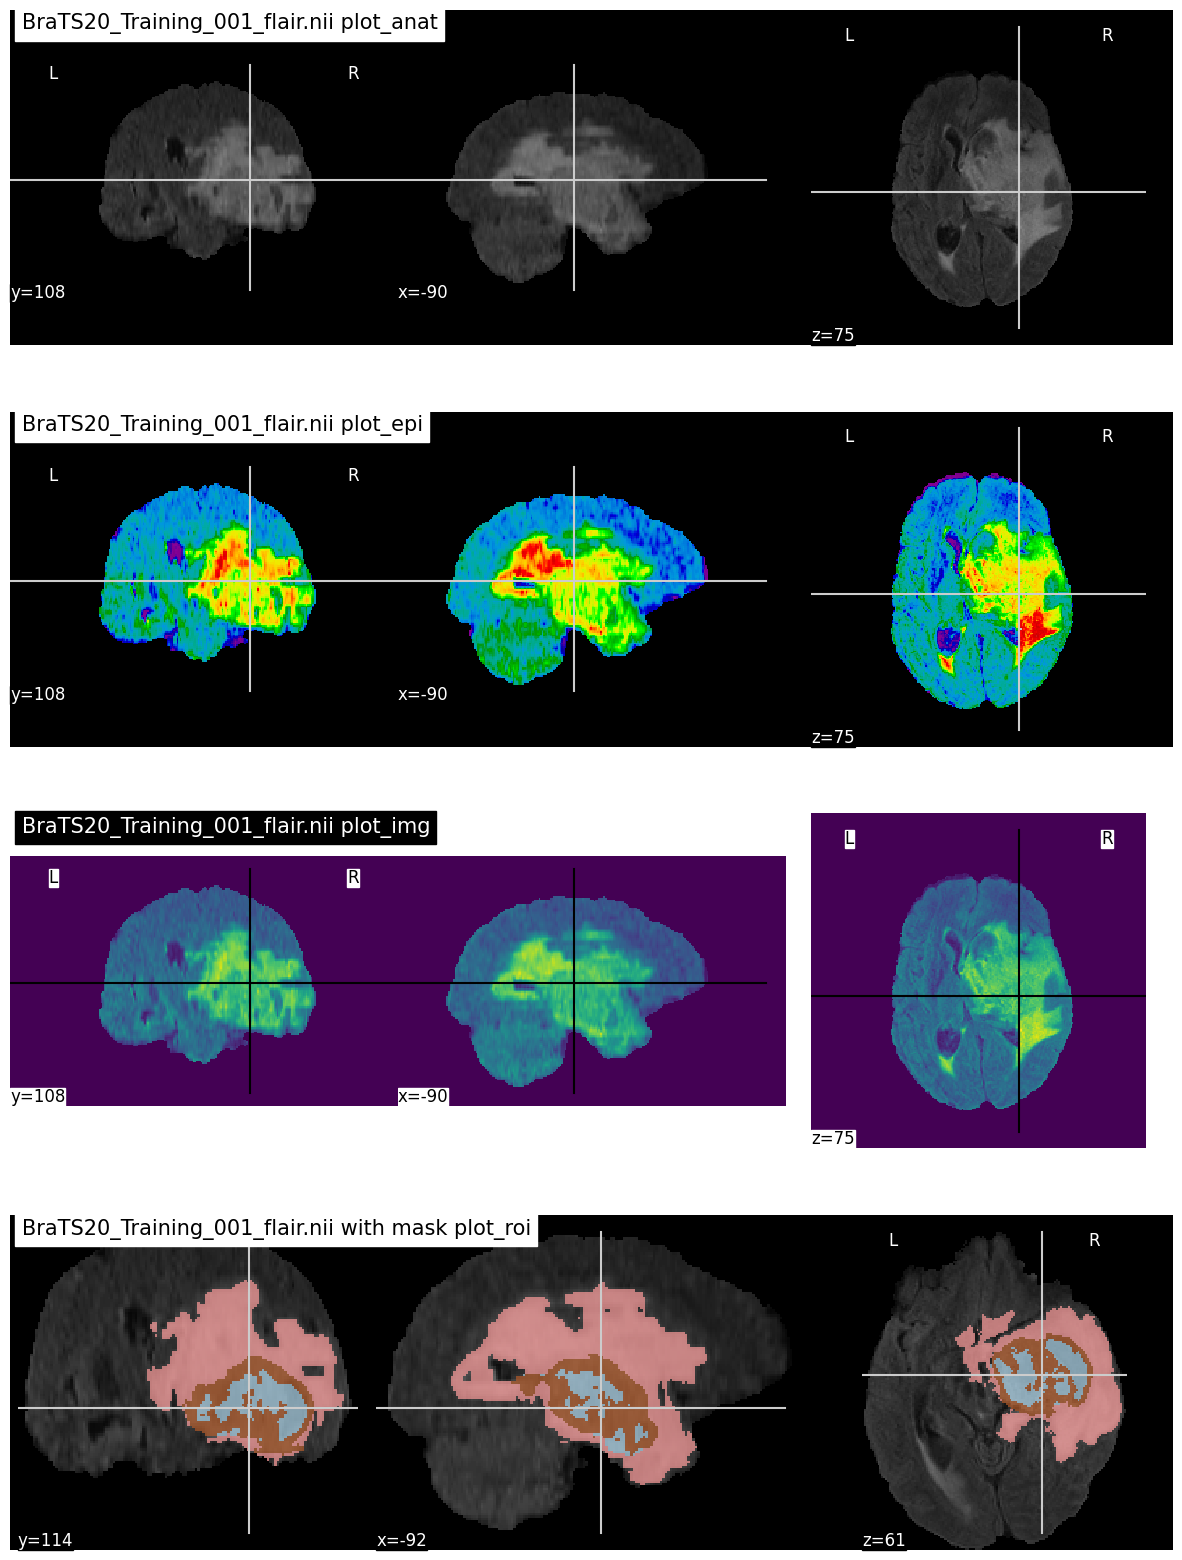

In [39]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(15, 20))  # Adjust figsize here

nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0]) #to plot anatomical images for visualization

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1]) #to plot functional images through Echo Planar Imaging (EPI)

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2]) #to plot different types of images, including anatomical, functional, and other types of images

nlplt.plot_roi(nimask,
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired') #for plotting Region of Interest (ROI) or mask images for visualizing specific brain areas

plt.show()

### **Functions to calculate the metrics**

In [40]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [41]:
IMG_SIZE=128

### **Model Architecture**

In [42]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

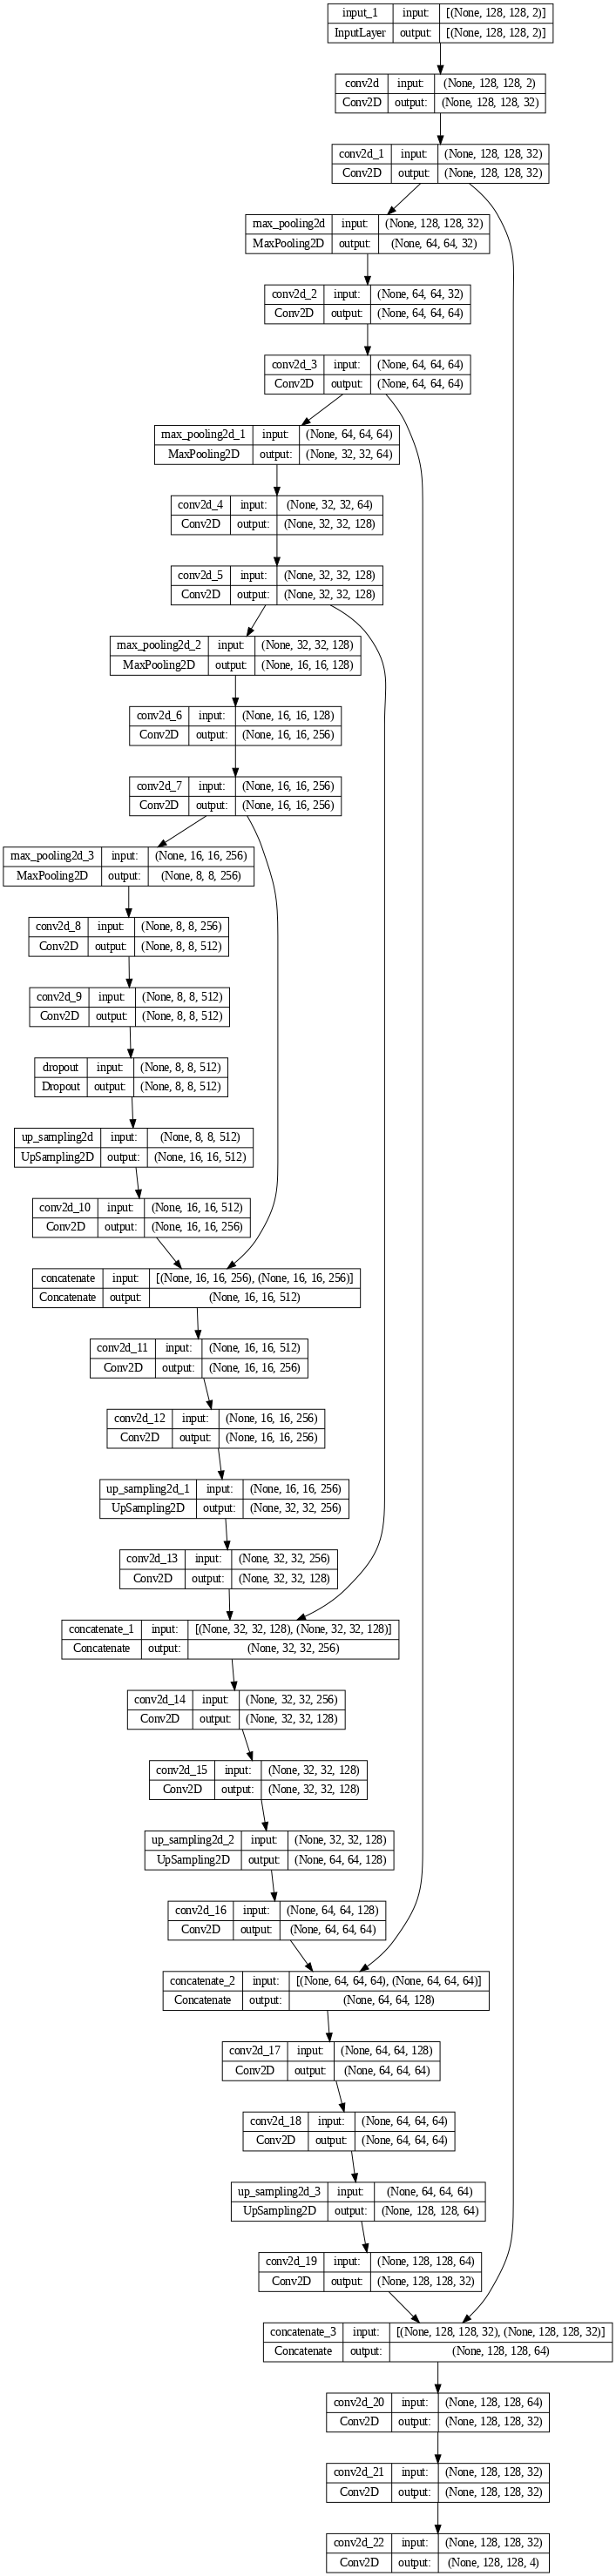

In [43]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

# Load data


In [44]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

**Override Keras sequence DataGenerator class**

In [45]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT];

        # Generate masks
        y[y == 4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X / np.max(X), Y

    def get_true_labels(self):
        'Returns true labels'
        true_labels = np.zeros((len(self.list_IDs) * VOLUME_SLICES, 240, 240))
        for c, i in enumerate(self.list_IDs):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                true_labels[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT];

        true_labels[true_labels == 4] = 3;
        true_labels = tf.one_hot(true_labels, 4);
        true_labels = tf.image.resize(true_labels, (IMG_SIZE, IMG_SIZE))
        return true_labels

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

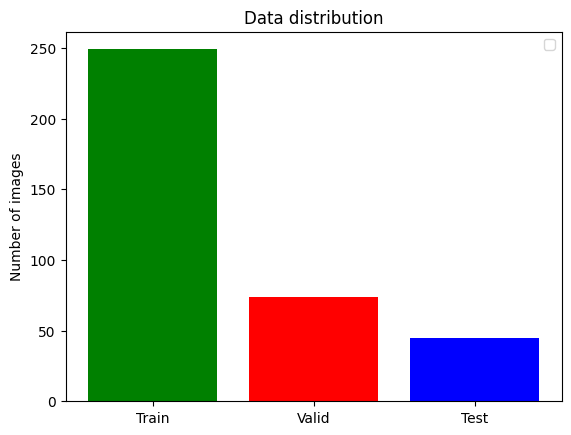

In [46]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

**Add callback for training process**

In [47]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
        csv_logger
    ]

# Train model
My model was trained and saved as model_per_class.h5 with 92% accuracy and 18% loss <br>
I will load this pretrained model instead of training again

In [48]:
K.clear_session()

# history =  model.fit(training_generator,
#                     epochs=35,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )
# # Save the model
# model_folder = "modelperclasseval"
# model_filename = "model_per_class.h5"
# if not os.path.exists(model_folder):
#     os.makedirs(model_folder)
# model_path = os.path.join(model_folder, model_filename)
# model.save(model_path)

# # Save the training history log
# log_filename = "training_per_class.log"
# log_path = os.path.join(model_folder, log_filename)
# with open(log_path, 'w') as log_file:
#     json.dump(history.history, log_file)

**Visualize the training process**

In [49]:
############ load trained model ################
model = keras.models.load_model('/content/modelperclasseval/model_per_class.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/modelperclasseval/training_per_class.log', sep=',', engine='python')

hist=history


In [50]:
hist.head(10)

,epoch,accuracy,dice_coef,dice_coef_edema,dice_coef_enhancing,dice_coef_necrotic,loss,lr,mean_io_u,precision,...,val_accuracy,val_dice_coef,val_dice_coef_edema,val_dice_coef_enhancing,val_dice_coef_necrotic,val_loss,val_mean_io_u,val_precision,val_sensitivity,val_specificity
0,0,0.980094,0.269054,0.128231,0.053186,0.052659,0.126133,0.001,0.630319,0.979349,...,0.981351,0.285636,0.177542,0.057288,0.090325,0.070609,0.733641,0.981184,0.981206,0.993740
1,1,0.983249,0.290646,0.186306,0.103781,0.105084,0.068515,0.001,0.665538,0.984875,...,0.981351,0.315330,0.221819,0.157583,0.165141,0.070638,0.795757,0.987576,0.973715,0.995801
2,2,0.983637,0.310294,0.235553,0.161110,0.137466,0.059598,0.001,0.500530,0.986235,...,0.981290,0.325683,0.241405,0.337313,0.151612,0.070288,0.422640,0.990787,0.969561,0.996822
3,3,0.985282,0.343751,0.326386,0.245297,0.187634,0.050178,0.001,0.468888,0.989813,...,0.980060,0.371073,0.422884,0.341000,0.234048,0.058415,0.423008,0.988346,0.972010,0.995963
4,4,0.985224,0.355187,0.335832,0.308869,0.184460,0.050873,0.001,0.401226,0.989890,...,0.986099,0.411275,0.427003,0.420307,0.237623,0.050433,0.414041,0.989045,0.982299,0.996248
5,5,0.985775,0.375934,0.364914,0.386879,0.197705,0.047365,0.001,0.449047,0.989752,...,0.984969,0.405599,0.448366,0.440261,0.246242,0.047539,0.800285,0.991324,0.978193,0.996950
6,6,0.987365,0.405154,0.446160,0.422335,0.251553,0.039764,0.001,0.560146,0.991530,...,0.985347,0.418042,0.424525,0.437941,0.326352,0.042376,0.392679,0.992049,0.979630,0.997187
7,7,0.988505,0.431410,0.481461,0.497490,0.277496,0.036101,0.001,0.530847,0.991948,...,0.985710,0.447531,0.557935,0.443875,0.281481,0.041521,0.559193,0.987689,0.983343,0.995887
8,8,0.988944,0.450328,0.517094,0.533350,0.283025,0.035486,0.001,0.442406,0.991510,...,0.986293,0.473235,0.524539,0.555260,0.377959,0.041449,0.415550,0.989724,0.982737,0.996522
9,9,0.989324,0.468279,0.548842,0.545668,0.334195,0.032760,0.001,0.440706,0.991844,...,0.988879,0.489921,0.602069,0.481150,0.377741,0.032994,0.483231,0.991248,0.986329,0.997024


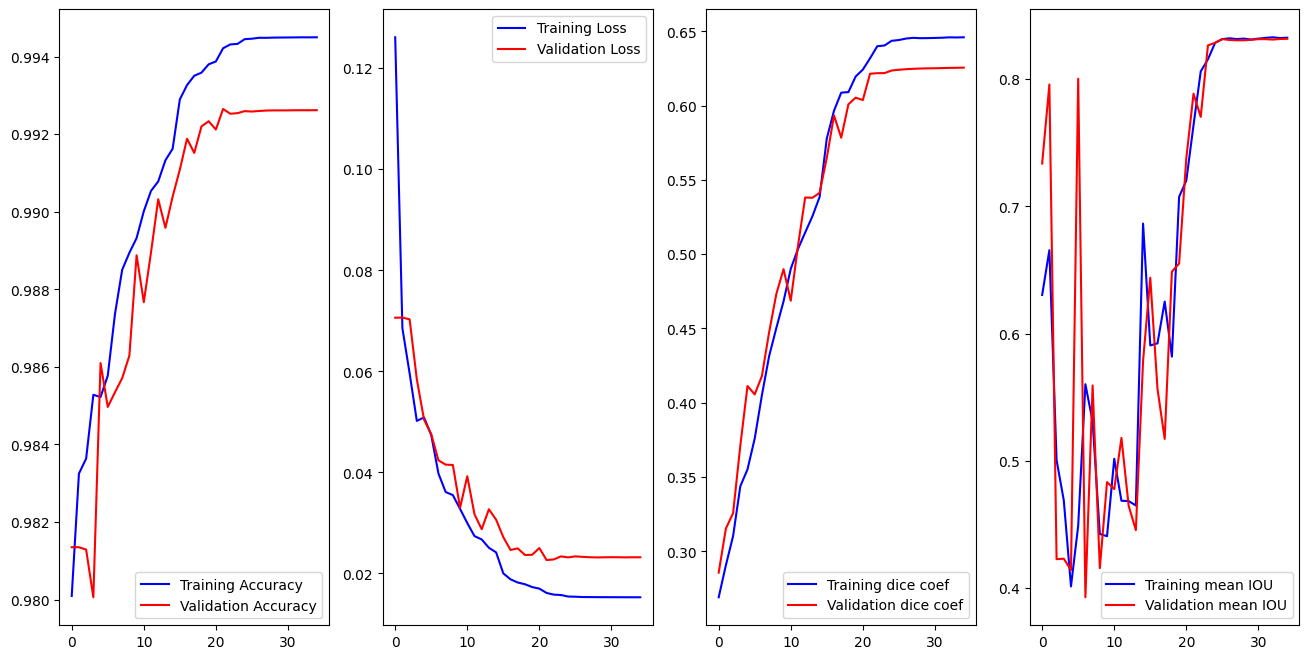

In [51]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Prediction examples

4/4 [==============================] - 1s 75ms/step


<Figure size 1800x5000 with 0 Axes>

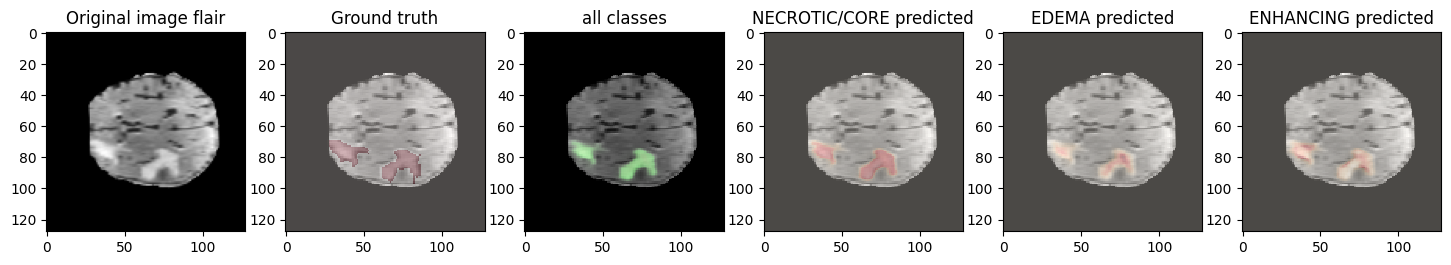

4/4 [==============================] - 0s 68ms/step


<Figure size 1800x5000 with 0 Axes>

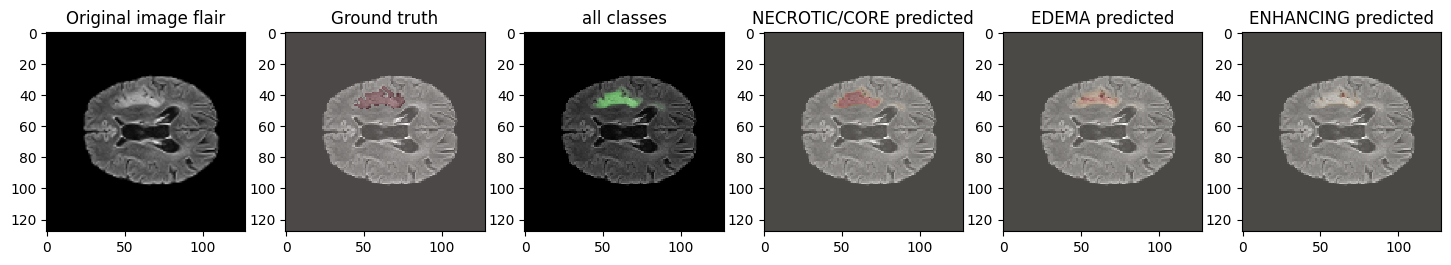

4/4 [==============================] - 0s 68ms/step


<Figure size 1800x5000 with 0 Axes>

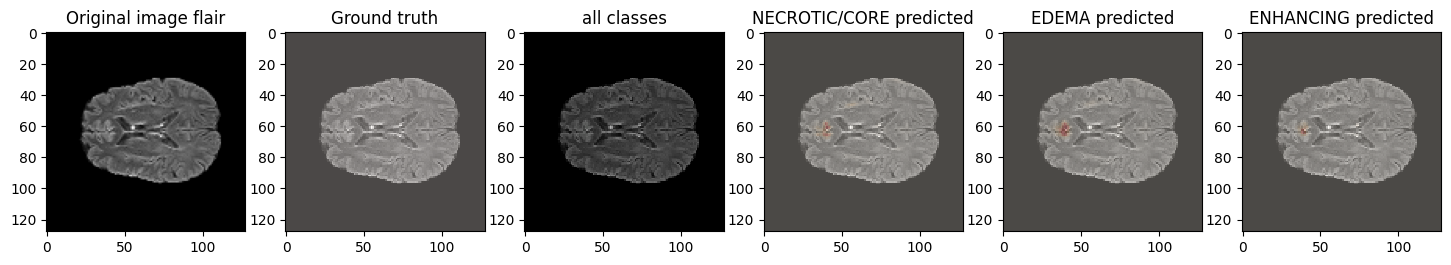

4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

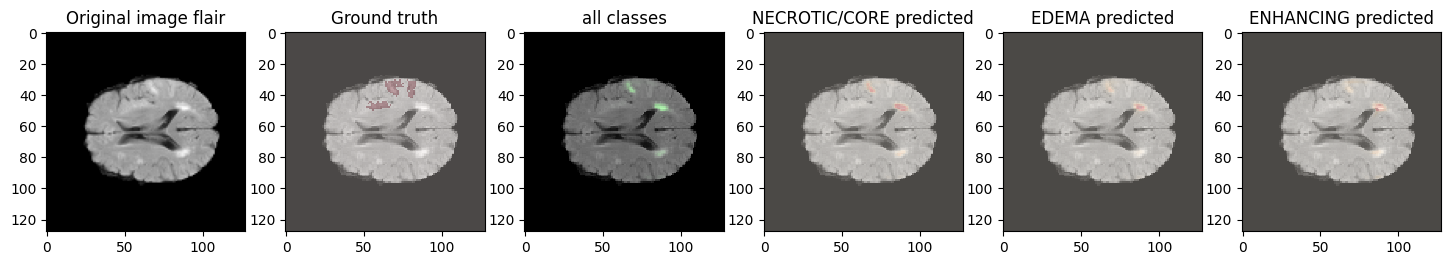

4/4 [==============================] - 0s 67ms/step


<Figure size 1800x5000 with 0 Axes>

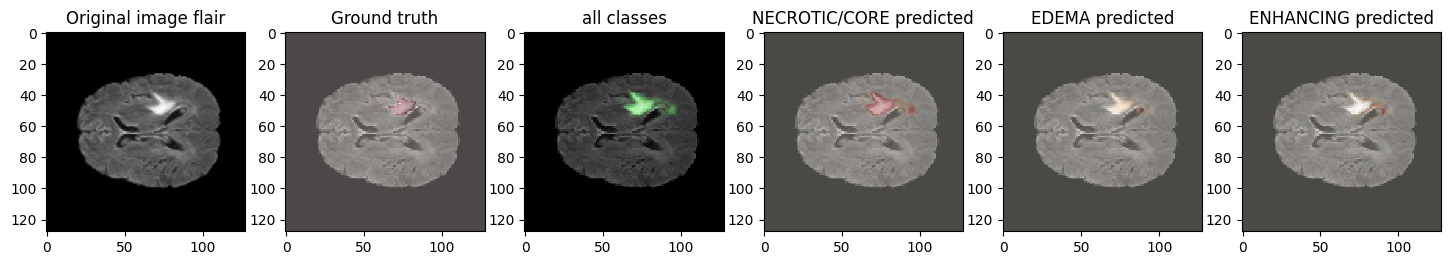

4/4 [==============================] - 0s 71ms/step


<Figure size 1800x5000 with 0 Axes>

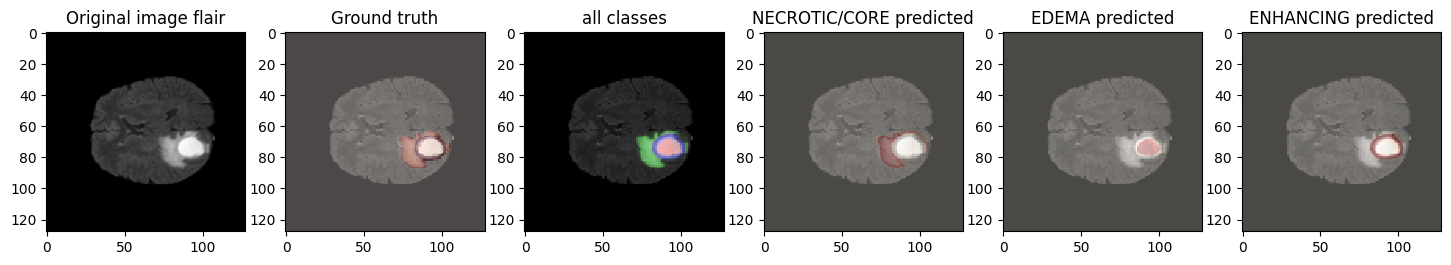

4/4 [==============================] - 0s 74ms/step


<Figure size 1800x5000 with 0 Axes>

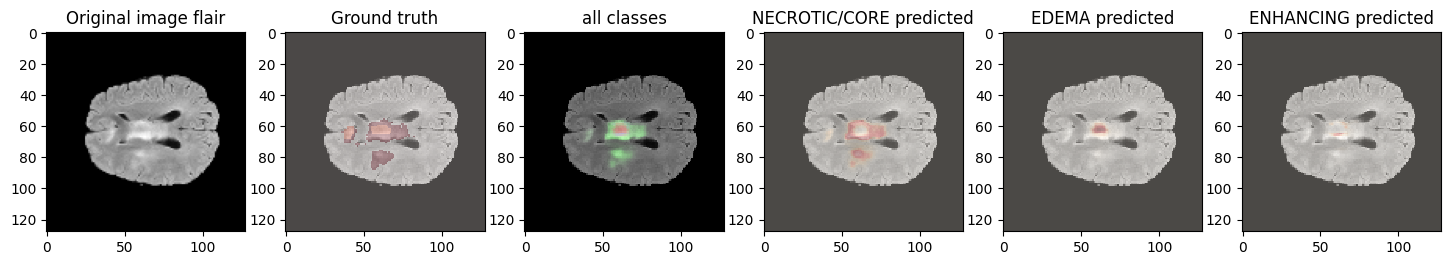

In [53]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# Evaluation

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("Test loss, Test acc, Mean IoU, Dice Coef, Precision, Sensitivity, Specificity, Dice Coef Necrotic, Dice Coef Edema, Dice Coef Enhancing:", results)

# Separate out the results
test_loss, test_acc, mean_iou, dice_coef_val, precision_val, sensitivity_val, specificity_val, dice_coef_necrotic_val, dice_coef_edema_val, dice_coef_enhancing_val = results

# Calculate recall
recall_val = sensitivity_val  # Recall and sensitivity are the same

# Compute F1 score
f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Mean IoU:", mean_iou)
print("Dice Coef:", dice_coef_val)
print("Precision:", precision_val)
print("Sensitivity (Recall):", sensitivity_val)
print("Specificity:", specificity_val)
print("Dice Coef Necrotic:", dice_coef_necrotic_val)
print("Dice Coef Edema:", dice_coef_edema_val)
print("Dice Coef Enhancing:", dice_coef_enhancing_val)
print("F1 Score:", f1_val)


Evaluate on test data
45/45 [==============================] - 18s 374ms/step - loss: 0.0173 - accuracy: 0.9940 - mean_io_u_2: 0.8289 - dice_coef: 0.6579 - precision: 0.9942 - sensitivity: 0.9927 - specificity: 0.9981 - dice_coef_necrotic: 0.6742 - dice_coef_edema: 0.7835 - dice_coef_enhancing: 0.7089
Test loss, Test acc, Mean IoU, Dice Coef, Precision, Sensitivity, Specificity, Dice Coef Necrotic, Dice Coef Edema, Dice Coef Enhancing: [0.017342811450362206, 0.9939939379692078, 0.828941822052002, 0.657872200012207, 0.9942461848258972, 0.9926532506942749, 0.9980550408363342, 0.6742292642593384, 0.7835088968276978, 0.708930492401123]
Test Loss: 0.017342811450362206
Test Accuracy: 0.9939939379692078
Mean IoU: 0.828941822052002
Dice Coef: 0.657872200012207
Precision: 0.9942461848258972
Sensitivity (Recall): 0.9926532506942749
Specificity: 0.9980550408363342
Dice Coef Necrotic: 0.6742292642593384
Dice Coef Edema: 0.7835088968276978
Dice Coef Enhancing: 0.708930492401123
F1 Score: 0.99344907

45/45 [==============================] - 13s 273ms/step


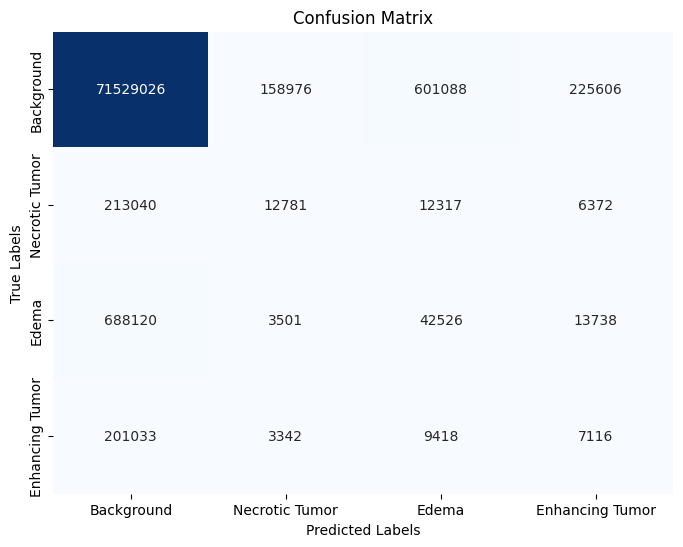

In [55]:
# Define class names
class_names = {
    0: "Background",
    1: "Necrotic Tumor",
    2: "Edema",
    3: "Enhancing Tumor"
}

# Predict classes for test data
y_pred = model.predict(test_generator)

# Convert true labels to binary
y_true_binary = np.argmax(test_generator.get_true_labels(), axis=3).reshape(-1)

# Convert predicted probabilities to binary predictions
y_pred_binary = np.argmax(y_pred, axis=3).reshape(-1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_binary, y_pred_binary)

# Plot confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=list(class_names.values()))
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=list(class_names.values()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
